# The Corporate Ladder

To test the hypothesis that a corporation's structure encodes an optimization procedure, we set up a basic toy model. To those familiar with ML, the proposed model bears some resemblance to boosting. 

Given a set $e = \{e_1,e_2,...,e_n\}$ of employees and $R(e_i,t)$ being reward to the company of employee $i$'s work at discrete time $t$, the "corporate model" ends up optimizing the average reward per employee.



In [2]:
import numpy as np
import matplotlib.pyplot as plt

## The model

An incoming employee $e_i$ has an internal $\mu_i \sim \mathcal{N}(0,1)$, which is constant per employee, and not known by the company. At each time step, the employee produces reward for the company $R(e_i,t) \sim \mathcal{N}(\mu_i,1)$, which is observed by the company.

The company has 5 promotion levels, where employees with higher reward are more likely to get promoted, and employees with lower reward are more likely to get demoted. 

An employee that goes below the 0 promotion level is fired, and replaced with a fresh employee.

To start off, we will use a direct promotion/demotion heuristic: any employee whose reward for a time step is over 1 standard deviation above the company average is promoted, and anyone below one standard deviation is demoted:

In [412]:
# Number of time steps to run
timesteps=1000

# The number of employees
n = 100

# The maximum number of promotions that an employee can have
maxPromotions = 5
firingThreshold = -1

# An employee is represented just by the mean of their reward distribution for this example. 
# You can change it to something else to explore more complicated distributions
def newEmployee():
    return np.random.normal()

# Given an employee, and their promotion level, output the employee and the reward they get
def rewardOutput(level, employee):
    # Return random number with the employee's mean, and the employee's mean does not change
    # wih time
    return np.random.normal(employee), employee

# Each time step, new employee levels are computed from the levels vector, and the corresponding vector of rewards
def employeeReview(levels,rewards):
    normalizedReward = (rewards-rewards.mean())/rewards.var()
    
    # Promote and demote one standard deviation
    levels[normalizedReward > 1] +=1
    levels[normalizedReward < -1] -=1
    
    return levels

Given the above, we run the simulation, and observe the result

Text(0.5, 1.0, 'Average Reward Per Time Step')

Text(0.5, 0, 'Time Step')

Text(0, 0.5, 'Reward')

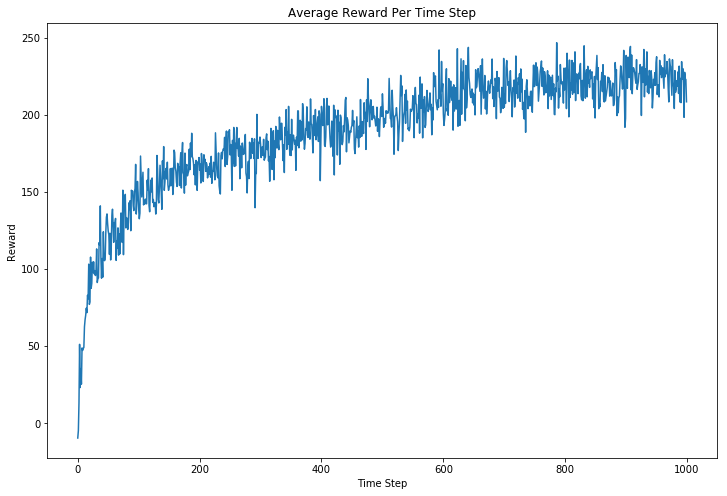

In [415]:

def runSimulation():
    # All employees start at level 1
    employeeLevel = np.zeros(n,dtype=int)
    employees = [newEmployee() for i in range(n)]

    totalReward = []
    meanReward = []
    employeeMean = []
    for t in range(timesteps):
        rewards = np.zeros(n)
        for i in range(n):
            rewards[i],employees[i] = rewardOutput(employeeLevel[i],employees[i])

        totalReward.append(rewards.sum())
        meanReward.append(rewards.mean())

        employeeLevel = employeeReview(employeeLevel,rewards)

        # Move people above max promotions back down
        employeeLevel[employeeLevel > maxPromotions] = maxPromotions
        # Fire everyone with level 0
        for i in np.nonzero(employeeLevel <=firingThreshold)[0]:
            #print("Replacing",i,employees[i])
            employees[i] = newEmployee()
            #print("With",employees[i])
        employeeLevel[employeeLevel <= firingThreshold] = 0
        #print("orderedLevels",employeeLevel[np.argsort(np.array(employees))],employeeLevel[np.argsort(np.array(employees))][0:int(len(employeeLevel)/2)].mean(),employeeLevel[np.argsort(np.array(employees))][int(len(employeeLevel)/2):].mean(),rewards[np.argsort(np.array(employees))])
        
    return totalReward,meanReward

totalReward,employeeMean = runSimulation()
plt.gcf().set_size_inches(12,8)
plt.title("Average Reward Per Time Step")
plt.xlabel("Time Step")
plt.ylabel("Reward")
plt.plot(totalReward)

This is a classic optimization curve. In less than 1000 time steps, the average employee at the company is over 2 standard deviations above the population average.

This result is pretty obvious: the entire goal of the hiring/firing process is to retain the best talent and get rid of those bringing the team down. However, it is what we did not explicitly state that is most important: the average employee at the company is over 2 standard deviations above the population average *at the metric being optimized*.

Maurice Hilleman (creator of the measles vaccine) would probably be quickly fired at a company selling homeopathic remedies, no matter how many lives his work saved. It is also questionable how long he would have lasted at a call center. Likewise, the creator of an open-source competitor to a company's cash-cow product is unlikely to be in good graces at the company.

It makes sense that the thing being optimized is the company's direct business goals, no matter what the HR or PR departments might say about "consumer benefit"

## Adding Stochasticity

My conclusions given above were a bit harsh. Let's suppose that times are good, so the company does not have shareholders breathing down the executives' necks to focus on optimizing profits (or whatever the company's charter specifies is the ultimate goal). Or maybe the company executives are simply bogged down in office politics and bureaucracy.

In such a situation, promotion/demotion might be only slightly correlated with reward. In this next example, high-reward employees have chances of promotion only 10% larger than low-reward employees. This simulates promotions and firing based mainly on other factors, be they office politics, "culture fit", or even benefit to humanity.

What does the model say now?

Text(0.5, 1.0, 'Average Reward Per Time Step')

Text(0.5, 0, 'Time Step')

Text(0, 0.5, 'Reward')

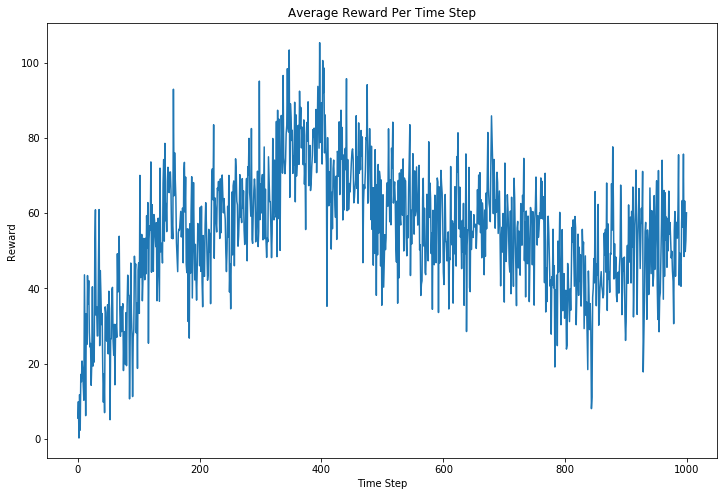

In [416]:
# Now, make the promotions and firing be probabilistic, based on performance.
# The employees are assumed to be ordered from least reward to highest
# The probability difference between promotion and demotion is just 10%, to show
# that even if there is just a tiny push in the direction of optimization...
pstart = 0.2
pend = 0.3
probabilityOfPromotion = arange(pstart,pend,step=(pend - pstart)/(n))
probabilityOfDemotion = np.flip(probabilityOfPromotion) #arange(pend,pstart,step=(pstart-pend)/(n))

def employeeReview(levels,rewards):
    # Set the threshold with a uniform 0,1
    promotionThreshold = np.random.uniform(size=len(rewards))
    demotionThreshold = np.random.uniform(size=len(rewards))
    
    indexOrder = np.argsort(np.argsort(rewards)) # We find the inverse of the argsort permutation to get index order
    
    return levels + (probabilityOfPromotion[indexOrder]>promotionThreshold) - 1*(probabilityOfDemotion[indexOrder]>demotionThreshold)

totalReward,employeeMean = runSimulation()
plt.gcf().set_size_inches(12,8)
plt.title("Average Reward Per Time Step")
plt.xlabel("Time Step")
plt.ylabel("Reward")
plt.plot(totalReward)

After 1000 time steps, the average employee is about half a standard deviation better at optimizing reward than the population at large. This means that the average employee is still a bit more focused on the company's business goals than the average person.


## Analysis

All that the above simulations specify is that a company's hiring and firing method ends up encoding a simple algorithm, optimizing for its goals. For a company focused entirely on its goal, it will hire and promote employees who are likewise singularly focused on that goal. To be clear: there is nothing wrong with this if those goals are correlated to benefit to humanity. There is also nothing wrong if the goals are orthogonal to benefit to humanity.

The issues only start if the thing being optimized ends up being *against* humans' best interests. For the full discussion please refer back to the blog.